In [1]:
import numpy as np
import pandas as pd
import os

from datasets import load_dataset, DatasetDict

import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

import matplotlib.pyplot as plt

In [2]:
INPUT_DIR = "/input0"
OUTPUT_DIR = "/output/output/xlm-roberta"
CHECKPOINT = "symanto/xlm-roberta-base-snli-mnli-anli-xnli"

In [3]:
# Load data
data = load_dataset("csv", data_files=os.path.join(INPUT_DIR, "train.csv"), trust_remote_code=True, split="train")
data = data.train_test_split(0.2)

data = DatasetDict(
    {
        "train": data["train"],
        "val": data["test"],
        "test": load_dataset("csv", data_files=os.path.join(INPUT_DIR, "test.csv"), trust_remote_code=True, split="train"),
    }
)

data

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 9696
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 2424
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language'],
        num_rows: 5195
    })
})

In [4]:
df = data["train"].to_pandas()
df.head()

,id,premise,hypothesis,lang_abv,language,label
0,526fb6300a,อาคารเก่าแก่แห่งนี้จัดการจัดการแสดง Edinburgh ...,อาคารมีการนำเสนอภาพนิ่ง 3D เกี่ยวกับประวัติศาส...,th,Thai,0
1,26eda399a9,did you well it's not just that are there enou...,there still aren't enough jobs for everyone here,en,English,2
2,e5faa29d99,"Although a mile long, its name is misleading b...","It is a mile long, each street spanning about ...",en,English,1
3,4a7224abd7,yeah yeah seven percent or something it depend...,It a place like Dallas it's seven percent.,en,English,2
4,e936568670,While documenting the basis for judgments can ...,Documenting nonjudgmental information can pose...,en,English,0


In [5]:
df[["premise", "hypothesis", "lang_abv", "language"]].describe()

,premise,hypothesis,lang_abv,language
count,9696,9696,9696,9696
unique,7055,9696,15,15
top,You can alternate lazy days on the beach with ...,อาคารมีการนำเสนอภาพนิ่ง 3D เกี่ยวกับประวัติศาส...,en,English
freq,3,1,5518,5518


In [6]:
df[["lang_abv", "language"]].value_counts()

lang_abv  language  
en        English       5518
zh        Chinese        323
ar        Arabic         322
sw        Swahili        313
hi        Hindi          309
ur        Urdu           304
fr        French         301
ru        Russian        300
vi        Vietnamese     296
th        Thai           295
es        Spanish        291
tr        Turkish        290
el        Greek          287
bg        Bulgarian      274
de        German         273
Name: count, dtype: int64

In [7]:
df.isna().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

In [8]:
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=3)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [9]:
def preprocess_data(batch):
    batch["text"] = [
        x1 + f" {tokenizer.sep_token} " + x2
        for x1, x2 in zip(batch["premise"], batch["hypothesis"])
    ]
    return tokenizer(batch["text"])

data = data.map(preprocess_data, batched=True)
data

Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 9696
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 2424
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'text', 'input_ids', 'attention_mask'],
        num_rows: 5195
    })
})

In [10]:
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=labels)


train_args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, "results"),
    logging_dir=os.path.join(OUTPUT_DIR, "logs"),
    report_to=[],
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    save_steps=200,
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.005,
    num_train_epochs=5,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=3,
    save_only_model=True,
)

train_args

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'gradient_accumulation_kwargs': None},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_steps=200,
evaluation_strategy=steps,
fp16=True,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_v2': False, 'xla_

In [11]:
trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=data["train"],
    eval_dataset=data["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(3)],
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
200,0.324200,0.301612,0.882426
400,0.360800,0.326739,0.878300
600,0.347300,0.302524,0.884488
800,0.241500,0.369915,0.885726
1000,0.202900,0.443394,0.880776
1200,0.234700,0.379496,0.879538
1400,0.180400,0.594200,0.880776


Using the latest cached version of the module from /root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--accuracy/f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Thu May  2 01:42:39 2024) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.


TrainOutput(global_step=1400, training_loss=0.27024753843035015, metrics={'train_runtime': 233.9322, 'train_samples_per_second': 207.24, 'train_steps_per_second': 12.952, 'total_flos': 957889064121696.0, 'train_loss': 0.27024753843035015, 'epoch': 2.31023102310231})

In [12]:
log = trainer.state.log_history
log

[{'loss': 0.3242,
  'grad_norm': 4.449669361114502,
  'learning_rate': 1.8706270627062708e-05,
  'epoch': 0.33003300330033003,
  'step': 200},
 {'eval_loss': 0.3016122281551361,
  'eval_accuracy': 0.8824257425742574,
  'eval_runtime': 4.4942,
  'eval_samples_per_second': 539.364,
  'eval_steps_per_second': 33.821,
  'epoch': 0.33003300330033003,
  'step': 200},
 {'loss': 0.3608,
  'grad_norm': 23.575103759765625,
  'learning_rate': 1.7392739273927396e-05,
  'epoch': 0.6600660066006601,
  'step': 400},
 {'eval_loss': 0.3267388641834259,
  'eval_accuracy': 0.8783003300330033,
  'eval_runtime': 105.8904,
  'eval_samples_per_second': 22.892,
  'eval_steps_per_second': 1.435,
  'epoch': 0.6600660066006601,
  'step': 400},
 {'loss': 0.3473,
  'grad_norm': 24.919466018676758,
  'learning_rate': 1.6072607260726074e-05,
  'epoch': 0.9900990099009901,
  'step': 600},
 {'eval_loss': 0.30252429842948914,
  'eval_accuracy': 0.8844884488448845,
  'eval_runtime': 3.7349,
  'eval_samples_per_second': 

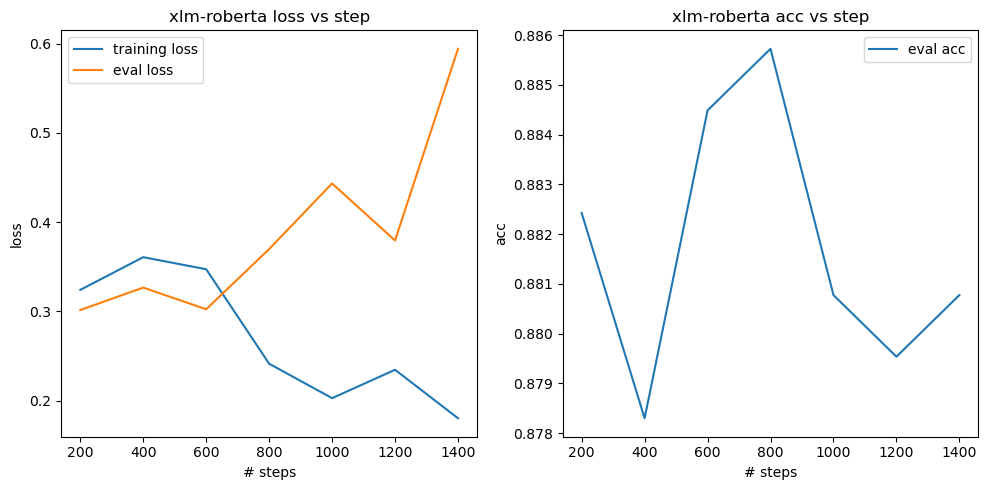

In [13]:
steps = []
train_loss = []
eval_loss = []
eval_acc = []

for i in range(0, len(log) - 1, 2):
    train_log = log[i]
    eval_log = log[i + 1]
    steps.append(train_log["step"])
    train_loss.append(train_log["loss"])
    eval_loss.append(eval_log["eval_loss"])
    eval_acc.append(eval_log["eval_accuracy"])

plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.title("xlm-roberta loss vs step")
plt.xlabel("# steps")
plt.ylabel("loss")
plt.plot(steps, train_loss, label="training loss")
plt.plot(steps, eval_loss, label="eval loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("xlm-roberta acc vs step")
plt.xlabel("# steps")
plt.ylabel("acc")
plt.plot(steps, eval_acc, label="eval acc")
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
preds = trainer.predict(data["test"])
preds

PredictionOutput(predictions=array([[-3.2832031, -2.7265625,  6.0351562],
       [-3.0117188,  5.828125 , -3.5039062],
       [ 6.3945312, -2.4941406, -2.5410156],
       ...,
       [ 6.2421875, -2.3613281, -2.4902344],
       [ 4.1367188, -1.5185547, -1.6474609],
       [-3.5859375, -1.8964844,  5.4257812]], dtype=float32), label_ids=None, metrics={'test_runtime': 3.7463, 'test_samples_per_second': 1386.711, 'test_steps_per_second': 86.753})

In [15]:
pd.DataFrame(
    {"id": data["test"]["id"], "prediction": np.argmax(preds.predictions, axis=1)}
).to_csv(os.path.join(OUTPUT_DIR, "submission.csv"), header=True, index=False)